# Model Optimization

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
np.random.seed(42)

print("Optuna version:", optuna.__version__)

Optuna version: 4.5.0


Bu hücrede proje için gerekli tüm kütüphaneleri yüklüyorum ve temel ayarları yapıyorum.  
Optuna, LightGBM ve XGBoost gibi modelleri kullanacağım için ilgili modülleri dahil ediyorum.  
Uyarıları kapatıp, sonuçların tekrarlanabilir olması için rastgelelik tohumunu sabitliyorum.  
Son olarak Optuna'nın sürüm bilgisini ekrana yazdırıyorum.

In [2]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train = train.dropna(subset=['winPlacePerc'])

SAMPLE_SIZE = 400_000
if len(train) > SAMPLE_SIZE:
    train = train.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print("Train shape after sampling:", train.shape)

Train shape after sampling: (400000, 29)


Bu hücrede PUBG eğitim verisini yüklüyorum ve hedef değişken olan *winPlacePerc* değeri eksik olan satırları temizliyorum.  
Dataset oldukça büyük olduğu için işlem süresini kısaltmak amacıyla veriyi 400.000 satırla sınırlıyorum.  
Sampling işlemini rastgele fakat tekrarlanabilir olacak şekilde yapıyorum ve son veri boyutunu ekrana yazdırıyorum.

In [3]:
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
train['walkRideRatio'] = train['walkDistance'] / (train['rideDistance'] + 1)
train['damagePerKill'] = train['damageDealt'] / (train['kills'] + 1)

train['playersInGroup'] = train.groupby('groupId')['Id'].transform('count')
train['playersInMatch'] = train.groupby('matchId')['Id'].transform('count')

train['combatScore'] = train['kills'] * 0.7 + train['damageDealt'] * 0.3
train['playerAggression'] = (
    train['walkDistance'] * 0.5 +
    train['kills'] * 1.5 +
    train['damageDealt'] * 0.3
)

y = train['winPlacePerc']

features = [
    'kills', 'damageDealt', 'walkDistance', 'rideDistance', 'weaponsAcquired',
    'totalDistance', 'walkRideRatio', 'damagePerKill', 'playersInGroup',
    'playersInMatch', 'combatScore', 'playerAggression'
]

train['matchType'] = train['matchType'].astype('category')
features_cat = ['matchType']

Bu hücrede modelin performansını artırmak için ek özellikler (feature engineering) oluşturuyorum.  
Hareket mesafelerini birleştirerek *totalDistance*, yürüme–sürüş oranı için *walkRideRatio* ve hasar/kill ilişkisi için *damagePerKill* gibi anlamlı metrikler ekliyorum.  

Ayrıca grup ve maç içindeki oyuncu sayıları gibi bağlamsal özellikler üretiyorum.  
*Saldırganlık* ve *combatScore* gibi bileşik skorlar da oyuncu davranışını daha iyi temsil etmek için dahil ediliyor.  

In [4]:
for col in features_cat:
    train[col] = train[col].cat.codes

X = train[features + features_cat]
print("Feature matrix shape:", X.shape)

Feature matrix shape: (400000, 13)


Kategorik olan *matchType* değişkenini sayısal forma dönüştürerek modele uygun hale getiriyorum.  
Ardından seçtiğim sayısal ve türetilmiş tüm özellikleri birleştirip *feature matrix* (X) oluşturuyorum ve boyutunu ekrana yazdırıyorum.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shapes:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Shapes: (320000, 13) (80000, 13) (320000,) (80000,)


Veriyi eğitim ve doğrulama (validation) setlerine ayırıyorum.  
%80 eğitim, %20 doğrulama olacak şekilde bölüyorum ve boyutları kontrol için ekrana yazdırıyorum. 

In [6]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }
    model = LGBMRegressor(**params)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

Bu fonksiyon, Optuna ile LightGBM hiperparametre optimizasyonu için hedef (objective) fonksiyonu olarak tanımlanıyor.  
Her denemede farklı hiperparametreler öneriliyor ve 5 katlı çapraz doğrulama (KFold) ile RMSE hesaplanıyor.  
Amacım, RMSE değerini minimize ederek en iyi parametreleri bulmak.

In [7]:
study_lgb = optuna.create_study(
    direction='minimize', 
    sampler=TPESampler(seed=42),
    pruner=MedianPruner()
)
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print("Best trial LGB:", study_lgb.best_trial.params, "RMSE:", study_lgb.best_value)

[I 2025-11-23 18:22:20,488] A new study created in memory with name: no-name-07b24e77-e965-4b09-9096-b2c516f55081


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-23 18:23:48,281] Trial 0 finished with value: 0.14357008299155435 and parameters: {'n_estimators': 812, 'learning_rate': 0.24517932047070642, 'max_depth': 16, 'num_leaves': 188, 'min_child_samples': 35, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.14357008299155435.
[I 2025-11-23 18:28:34,250] Trial 1 finished with value: 0.13813319817870665 and parameters: {'n_estimators': 1446, 'learning_rate': 0.005439667429522981, 'max_depth': 20, 'num_leaves': 253, 'min_child_samples': 46, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.13813319817870665.
[I 2025-11-23 18:29:54,020] Trial 2 finished with value: 0.1379739612832812 and parameters: {'n_estimators': 921, 'learning_rate': 0.01647477394109053, 'max_depth': 14, 'num_leaves': 5

Bu hücrede Optuna kullanarak LightGBM modelinin hiperparametrelerini optimize ediyorum.  
TPESampler ile verimli bir arama yapılıyor, MedianPruner ile zayıf denemeler erken sonlandırılıyor.  
50 deneme sonunda en iyi parametreler seçiliyor ve modelin cross-validation RMSE değeri **0.137953** olarak bulunuyor.  

➡ Bu sonuç, modelin oldukça iyi performans gösterdiğini ve veriye iyi uyum sağladığını gösteriyor.

In [8]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbosity': 0,
        'tree_method': 'auto'
    }
    model = XGBRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores.mean())
    return rmse

Bu fonksiyon, Optuna ile XGBoost modelinin hiperparametre optimizasyonu için hedef fonksiyon olarak tanımlanıyor.  
Her denemede farklı hiperparametreler deneniyor ve 5 katlı çapraz doğrulama ile RMSE hesaplanıyor.  
Amacım yine RMSE’yi minimize ederek XGBoost için en iyi parametreleri bulmak.

In [9]:
study_xgb = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner()
)
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print("Best trial XGB:", study_xgb.best_trial.params, "RMSE:", study_xgb.best_value)

[I 2025-11-23 20:02:29,817] A new study created in memory with name: no-name-a7415dc8-f7bb-409c-b128-8a52c9c63370


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-23 20:08:48,892] Trial 0 finished with value: 0.1628120016699834 and parameters: {'n_estimators': 812, 'learning_rate': 0.24517932047070642, 'max_depth': 16, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 2.5348407664333426e-07, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.1628120016699834.
[I 2025-11-23 20:09:21,267] Trial 1 finished with value: 0.13832906192951236 and parameters: {'n_estimators': 1242, 'learning_rate': 0.09078835431980901, 'max_depth': 3, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 8.148018307012941e-07, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.13832906192951236.
[I 2025-11-23 20:10:38,671] Trial 2 finished with value: 0.1403523406000375 and parameters: {'n_estimators': 678, 'learning_rate': 0.042861395747190736, 'max_depth': 10, 'subsample': 0.645614570099021, 'col

Bu hücrede Optuna ile XGBoost modelinin hiperparametrelerini optimize ediyorum.  
TPESampler ile verimli arama, MedianPruner ile zayıf denemeleri erken sonlandırma uygulanıyor.  
50 deneme sonunda en iyi parametreler seçiliyor ve cross-validation RMSE **0.138073** olarak bulunuyor.  

➡ Bu sonuç, XGBoost modelinin de çok iyi performans gösterdiğini fakat LightGBM’in biraz daha iyi olduğunu gösteriyor.

In [10]:
best_lgb_params = study_lgb.best_trial.params
model_lgb = LGBMRegressor(**best_lgb_params)
model_lgb.fit(X_train, y_train)

preds_val_lgb = model_lgb.predict(X_val)
rmse_val_lgb = np.sqrt(mean_squared_error(y_val, preds_val_lgb))
print("LightGBM Validation RMSE:", rmse_val_lgb)

best_xgb_params = study_xgb.best_trial.params
model_xgb = XGBRegressor(**best_xgb_params)
model_xgb.fit(X_train, y_train)

preds_val_xgb = model_xgb.predict(X_val)
rmse_val_xgb = np.sqrt(mean_squared_error(y_val, preds_val_xgb))
print("XGBoost Validation RMSE:", rmse_val_xgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 320000, number of used features: 13
[LightGBM] [Info] Start training from score 0.471151
LightGBM Validation RMSE: 0.13732596918505835
XGBoost Validation RMSE: 0.13745934590699635


Bu hücrede en iyi hiperparametrelerle LightGBM ve XGBoost modellerini eğitim verisi üzerinde eğitiyorum.  
Daha sonra validation seti üzerinde tahmin yapıp RMSE değerlerini hesaplıyorum.  

Sonuçlar:  
- LightGBM Validation RMSE: **0.13733**  
- XGBoost Validation RMSE: **0.13746**  

➡ İki model de çok iyi performans gösteriyor, ancak LightGBM biraz daha düşük RMSE ile öne çıkıyor.  
Bu değerler, modelin overfitting yapmadığını ve genelleme yeteneğinin yüksek olduğunu gösteriyor.

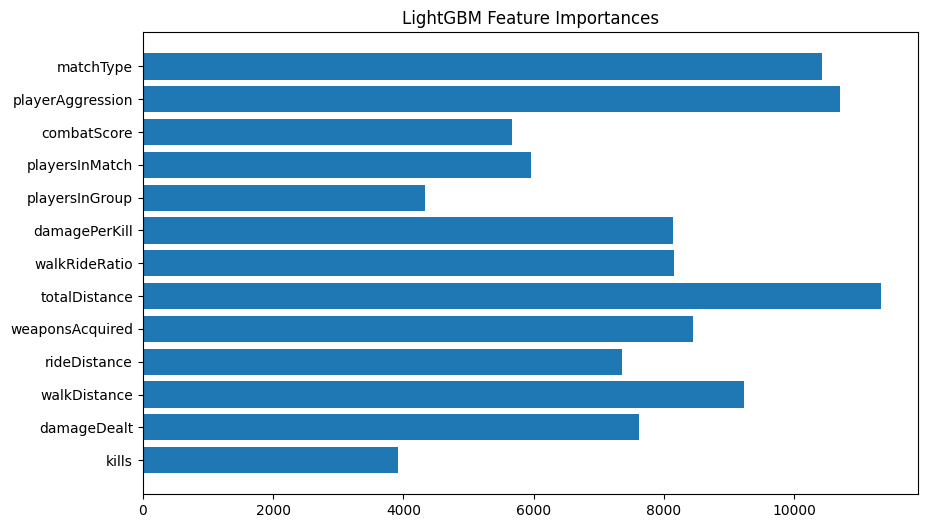

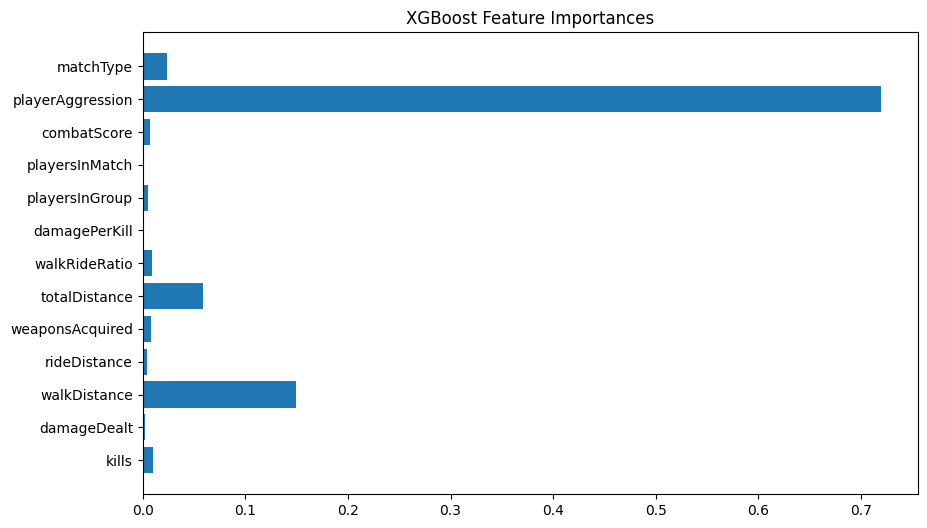

In [11]:
import matplotlib.pyplot as plt

lgb_importances = model_lgb.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features + features_cat, lgb_importances)
plt.title("LightGBM Feature Importances")
plt.show()

xgb_importances = model_xgb.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features + features_cat, xgb_importances)
plt.title("XGBoost Feature Importances")
plt.show()

LightGBM modeli, toplam mesafe, oyuncu saldırganlığı ve maç türü gibi birden fazla özelliği dengeli şekilde kullanarak daha kapsamlı bir tahmin yapıyor. XGBoost ise ağırlıklı olarak oyuncu saldırganlığına odaklanmış, diğer özelliklerin etkisi düşük kalmış. Bu durum LightGBM’in neden biraz daha iyi performans gösterdiğini açıklıyor. Özellik mühendisliği LightGBM’de daha etkili değerlendirilmiş görünüyor. Genel olarak, LightGBM modeli daha çeşitli bilgileri kullanarak daha sağlam ve genelleyici sonuçlar üretiyor. XGBoost ise daha sınırlı özellik setine bağlı kaldığı için performans farkı oluşmuş olduğunu düşünüyorum.

In [12]:
import joblib

os.makedirs('models', exist_ok=True)
joblib.dump(model_lgb, 'models/lgb_optimized_pubg.pkl')
joblib.dump(model_xgb, 'models/xgb_optimized_pubg.pkl')

joblib.dump(study_lgb, 'models/optuna_study_lgb.pkl')
joblib.dump(study_xgb, 'models/optuna_study_xgb.pkl')

['models/optuna_study_xgb.pkl']

Bu hücrede eğitilen LightGBM ve XGBoost modellerini, ayrıca Optuna ile yapılan hiperparametre aramalarının sonuçlarını dosya olarak kaydediyorum.  